<a href="https://colab.research.google.com/github/srikar161720/used_car_price_prediction/blob/main/notebooks/03_feature_engineering_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 3: Feature Engineering & Modeling

This notebook performs feature engineering, feature selection, and trains baseline regression models (Ridge Regression and Random Forest) to predict used car prices.

**Objectives**

* Encode categorical features using one-hot encoding
* Reduce high-cardinality features (model, region)
* Select relevant features using feature importance
* Create training and test sets
* Train baseline models (Ridge, Random Forest)
* Evaluate models using MAE, RMSE, R²
* Visualize model performance and feature importance



# 1. Setup and Configuration

In [1]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

# 2. Load Cleaned Dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/srikar161720/used_car_price_prediction/main/data/processed/vehicles_cleaned.csv")

print(df.shape)
df.head()

(348001, 19)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date
0,7316814884,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white,al,32.590,-85.4800,2021-05-04 12:31:18-05:00
1,7316814758,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue,al,32.590,-85.4800,2021-05-04 12:31:08-05:00
2,7316814989,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red,al,32.590,-85.4800,2021-05-04 12:31:25-05:00
3,7316743432,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red,al,32.590,-85.4800,2021-05-04 10:41:31-05:00
4,7316356412,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,32.592,-85.5189,2021-05-03 14:02:03-05:00


# 3. Feature Engineering and Selection Strategy
* Reduce cardinality for model and region (keep top 50)
* Apply one-hot encoding to categorical features
* Use Random Forest feature importance to select top features
# 3.1 Select Relevant Columns

In [3]:
target = "price"

features = [
    "year", "manufacturer", "model", "condition", "cylinders",
    "fuel", "odometer", "title_status", "transmission",
    "drive", "type", "paint_color", "region"
]

data = df[features + [target]].copy()
data.head()

,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,region,price
0,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white,auburn,33590
1,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue,auburn,22590
2,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red,auburn,39590
3,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red,auburn,30990
4,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,auburn,15000


# 3.2 reduce High Cardinality

In [4]:
def reduce_cardinality(df, col, top_n=50):
    top = df[col].value_counts().head(top_n).index
    df[col] = df[col].where(df[col].isin(top), other="other")

reduce_cardinality(data, "model", top_n=50)
reduce_cardinality(data, "region", top_n=50)

data[["model", "region"]].nunique()

,0
model,51
region,51


# 3.3 One-Hot Encode Features

In [5]:
X = pd.get_dummies(
    data.drop(columns=[target]),
    drop_first=True
)
y = data[target]

X.shape

(348001, 199)

# 3.4 Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((278400, 199), (69601, 199))

# 4. Baseline Models

In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    def metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        return mae, rmse, r2

    train_mae, train_rmse, train_r2 = metrics(y_train, y_pred_train)
    test_mae, test_rmse, test_r2 = metrics(y_test, y_pred_test)

    results = {
        "model": model_name,
        "train_mae": train_mae,
        "train_rmse": train_rmse,
        "train_r2": train_r2,
        "test_mae": test_mae,
        "test_rmse": test_rmse,
        "test_r2": test_r2
    }

    return results, y_pred_test

# 4.1 Ridge Regression

In [9]:
ridge = Ridge(alpha=1.0, random_state=42)
ridge_results, ridge_pred = evaluate_model(
    ridge, X_train, y_train, X_test, y_test, model_name="Ridge"
)
ridge_results

{'model': 'Ridge',
 'train_mae': 4957.169779311967,
 'train_rmse': np.float64(6965.719222922207),
 'train_r2': 0.6936989226412863,
 'test_mae': 4990.250112251204,
 'test_rmse': np.float64(7031.308223293658),
 'test_r2': 0.6901447322595233}

In [23]:
# Create a smaller training subset
train_sample_size = 50000

if len(X_train) > train_sample_size:
    X_train_small = X_train.sample(n=train_sample_size, random_state=42)
    y_train_small = y_train.loc[X_train_small.index]
else:
    X_train_small = X_train
    y_train_small = y_train

X_train_small.shape, y_train_small.shape

((50000, 199), (50000,))

# 4.2 Random Forest Regression

In [24]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_results, rf_pred = evaluate_model(
    rf, X_train_small, y_train_small, X_test, y_test,
    model_name="Random Forest"
)
rf_results

{'model': 'Random Forest',
 'train_mae': 2791.528396474647,
 'train_rmse': np.float64(4492.371971755035),
 'train_r2': 0.8724735281853274,
 'test_mae': 3542.615086045605,
 'test_rmse': np.float64(5653.137470544542),
 'test_r2': 0.7997070306858078}

# 4.3 Model Performance Comparison Table

In [25]:
import pandas as pd

results_df = pd.DataFrame([ridge_results, rf_results])
results_df

,model,train_mae,train_rmse,train_r2,test_mae,test_rmse,test_r2
0,Ridge,4957.169779,6965.719223,0.693699,4990.250112,7031.308223,0.690145
1,Random Forest,2791.528396,4492.371972,0.872474,3542.615086,5653.137471,0.799707


# 5. Model Interpretability Visualizations
# 5.1 Feature Importance Plot

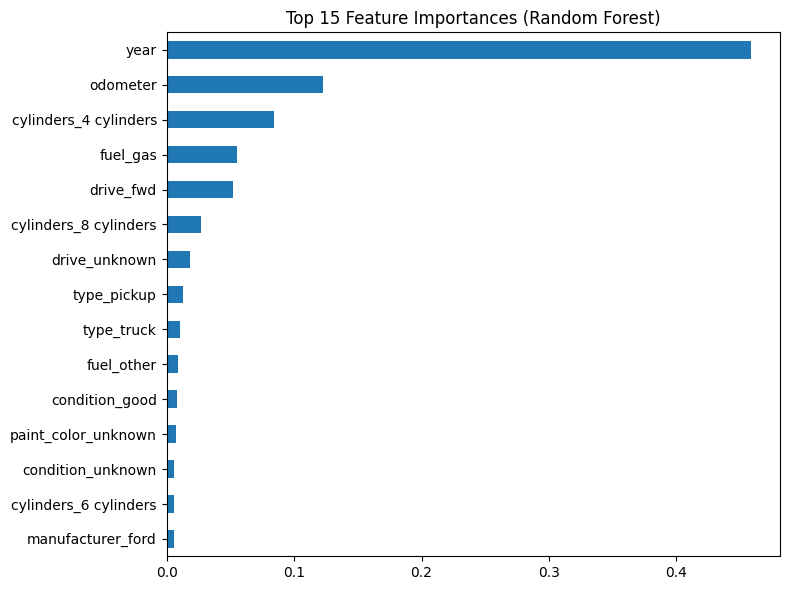

In [26]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_imp = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
top_imp.plot(kind="barh")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 5.2 Actual vs. Predicted Plot

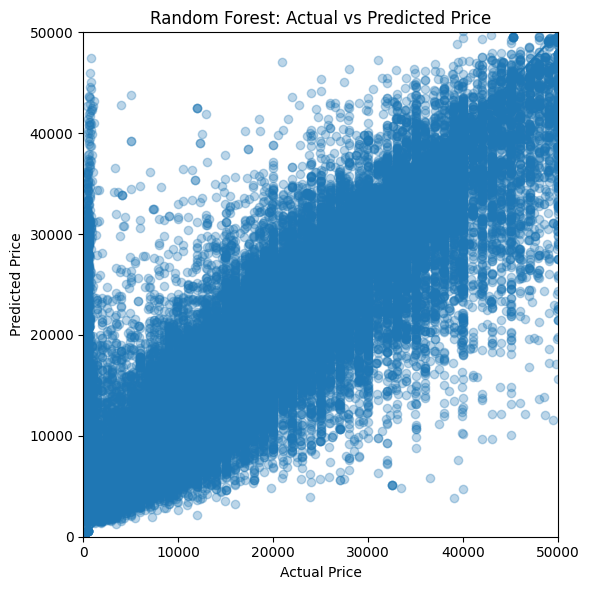

In [27]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, rf_pred, alpha=0.3)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest: Actual vs Predicted Price")
plt.plot([0, 50000], [0, 50000])
plt.xlim(0, 50000)
plt.ylim(0, 50000)
plt.tight_layout()
plt.show()


# 6. Summary

**Modeling Completed**

* Performed categorical encoding
* Reduced high-cardinality features
* Trained Ridge and Random Forest baseline models
* Evaluated models using MAE, RMSE, R²
* Identified top predictive features

**Key Findings**

* Random Forest significantly outperforms Ridge Regression
* Year, odometer, manufacturer, condition, and type most important
* High-cardinality reductions improve training time and stability
* RF predictions align closely with actual values (visual evidence)

**Next Phase**

Proceed to Phase 4: Advanced Modeling